In [1]:
import json
import pandas as pd
from pprint import pformat
from tabulate import tabulate
import textwrap

In [2]:
def load_json(json_path):
    """Load JSON data from a file."""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

In [116]:
def smart_wrap(val, width=100):
        if isinstance(val, (dict, list)):
            return pformat(val, width=width, compact=False)
        elif isinstance(val, str):
            return textwrap.fill(val, width=width)
        else:
            return str(val)

In [117]:
def get_random_row(dataf):
    random_row = dataf.sample(1).iloc[0]
    table_data = [(col, smart_wrap(val)) for col, val in random_row.items()]
    print(tabulate(table_data, headers=["Column", "Value"], tablefmt="fancy_grid"))
    return random_row

In [40]:
def merge_on_index_num(df1, model1, df2, model2):
    df1_valid = df1[df1['response'].apply(lambda x: isinstance(x, dict))].copy()
    df2_valid = df2[df2['response'].apply(lambda x: isinstance(x, dict))].copy()
    valid_indices = set(df1_valid['index_num']) & set(df2_valid['index_num'])
    df1_valid = df1_valid[df1_valid['index_num'].isin(valid_indices)]
    df2_valid = df2_valid[df2_valid['index_num'].isin(valid_indices)]
    merged_df = pd.merge(df1_valid, df2_valid, on='index_num', suffixes=("_" + model1, "_" + model2))
    if (merged_df["seed_"+model1] == merged_df["seed_"+model2]).all():
        merged_df = merged_df.drop(columns="seed_"+model2)
    return merged_df

In [103]:
def flatten_response(dd):
    response_fields = list(dd['response_gpt4_5'][0].keys())
    for field in response_fields:
        for suffix in ['gemma', 'gpt4_5']:
            try:
                dd[f'{field}_rating_{suffix}'] = dd[f'response_{suffix}'].apply(lambda x: float(x[field]['rating']))
                dd[f'{field}_reason_{suffix}'] = dd[f'response_{suffix}'].apply(lambda x: x[field]['reason'])
            except:
                dd[f'{field}_rating_{suffix}'] = None
                dd[f'{field}_reason_{suffix}'] = None
                continue
    return dd

## Visualize data for different skills

In [7]:
# The questions parsed json has both the texts and instruction-reponse pairs
ir_path = "/datadrive/pavan/az_storage/data_unorganized/age_0_5/questions/"
q1 = load_json(ir_path + '/conv/parsed.json')
q2 = load_json(ir_path + '/poem/parsed.json')
q3 = load_json(ir_path + '/story/parsed.json')

In [8]:
df1 = pd.DataFrame(q1)
df2 = pd.DataFrame(q2)
df3 = pd.DataFrame(q3)
df = pd.concat([df1, df2, df3], ignore_index=True)

<Axes: xlabel='skill'>

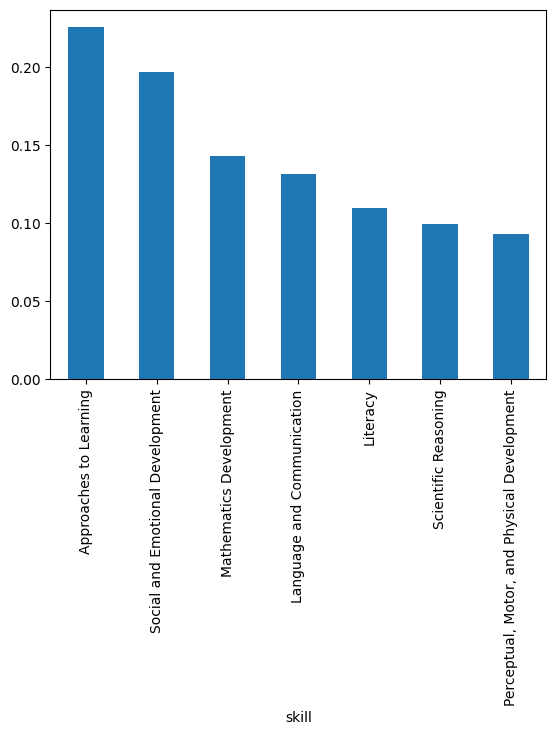

In [9]:
df['skill'].value_counts(normalize=True).plot(kind='bar')

In [10]:
skill_name = 'Approaches to Learning'
sk = df[df['skill'] == skill_name].reset_index(drop=True)

<Axes: xlabel='sub_skill'>

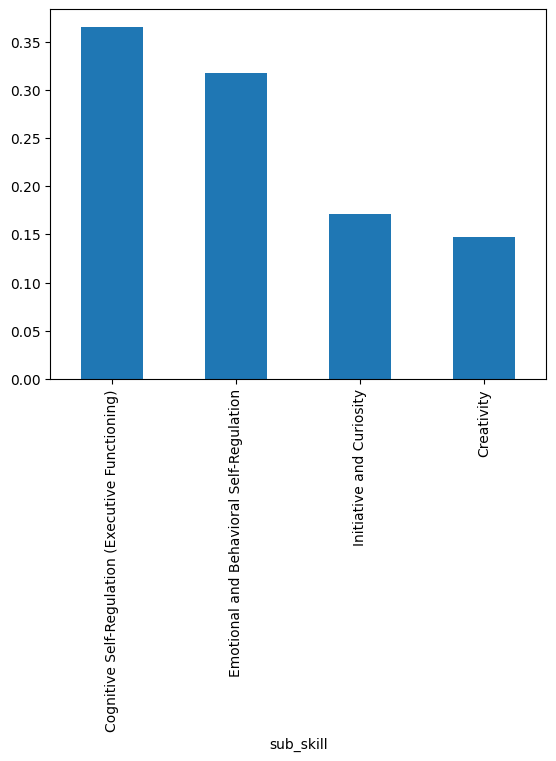

In [11]:
sk['sub_skill'].value_counts(normalize=True).plot(kind='bar')

In [12]:
r = get_random_row(sk)

╒═══════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Column    │ Value                                                                                                                                                  │
╞═══════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ output    │ {'ir': [{'instruction': 'Leo wanted to play with the water table right away, even though it was cold. If *you* wanted to build a really tall tower '   │
│           │                         "with blocks, but you didn't have the right size blocks, what would you do? Would you give up, or try to find a way to make "  │
│           │                         'it work?',                                                                                                                    

## Visualize verified data

In [86]:
# poem and ir based on poem
gemma = "/datadrive/pavan/az_storage/data_unorganized/age_0_5/texts/poem/random_5000_verified_gemma.json"
gpt4_5 = "/datadrive/pavan/az_storage/data_unorganized/age_0_5/texts/poem/random_5000_verified_gpt4_5.json"
gpt4_5 = pd.DataFrame(load_json(gpt4_5))
gemma = pd.DataFrame(load_json(gemma))

In [ ]:
df = merge_on_index_num(gemma, 'gemma', gpt4_5, 'gpt4_5')
df = pd.concat([df.drop(columns='seed_gemma'), pd.json_normalize(df['seed_gemma'])], axis=1)
df = flatten_response(df)

In [109]:
df.columns

Index(['response_gemma', 'index_num', 'response_gpt4_5', 'skill', 'sub_skill',
       'goal', 'indicator', 'topic', 'content', 'rhythm_and_flow_rating_gemma',
       'rhythm_and_flow_reason_gemma', 'rhythm_and_flow_rating_gpt4_5',
       'rhythm_and_flow_reason_gpt4_5', 'relevance_to_topic_rating_gemma',
       'relevance_to_topic_reason_gemma', 'relevance_to_topic_rating_gpt4_5',
       'relevance_to_topic_reason_gpt4_5', 'skill_reinforcement_rating_gemma',
       'skill_reinforcement_reason_gemma', 'skill_reinforcement_rating_gpt4_5',
       'skill_reinforcement_reason_gpt4_5', 'age_appropriateness_rating_gemma',
       'age_appropriateness_reason_gemma', 'age_appropriateness_rating_gpt4_5',
       'age_appropriateness_reason_gpt4_5', 'overall_quality_rating_gemma',
       'overall_quality_reason_gemma', 'overall_quality_rating_gpt4_5',
       'overall_quality_reason_gpt4_5', 'reasoning_rating_gemma',
       'reasoning_reason_gemma', 'reasoning_rating_gpt4_5',
       'reasoning_reaso

<Axes: xlabel='overall_quality_rating_gemma'>

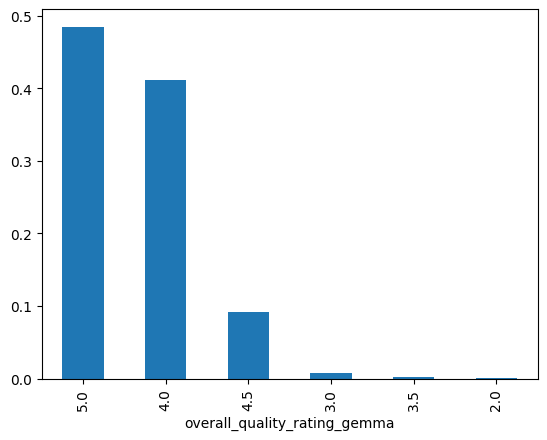

In [113]:
metric_names = ["rhythm_and_flow", "overall_quality"]
metric_name = metric_names[1]
df[f"{metric_name}_rating_gemma"].value_counts(normalize=True).plot(kind='bar')

<Axes: xlabel='overall_quality_rating_gpt4_5'>

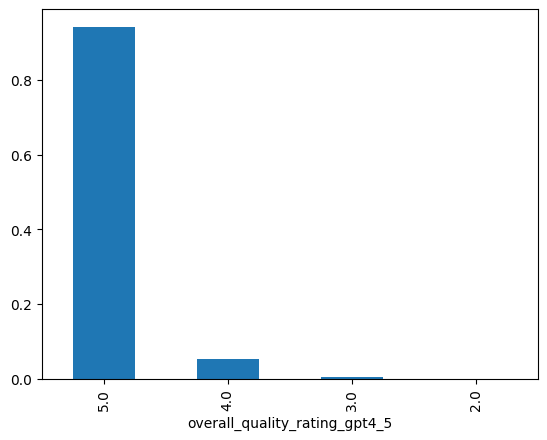

In [114]:
df[f"{metric_name}_rating_gpt4_5"].value_counts(normalize=True).plot(kind='bar')

In [118]:
r = get_random_row(df)

╒═══════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Column                            │ Value                                                                                                │
╞═══════════════════════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ response_gemma                    │ {'age_appropriateness': {'rating': '5',                                                              │
│                                   │                          'reason': 'The vocabulary is simple and age-appropriate, using words a '    │
│                                   │                                    "5-year-old would easily understand. The concepts of 'feeling "   │
│                                   │                                    "blue' and 'big feelings' are relatable for this age group."},    │
│            